# Exercise - Smart Routing System - SOLUTION

In this exercise, you will implement a comprehensive routing system that combines all three routing patterns we learned:
1. **Priority-Based Routing** - Assess urgency first
2. **Content-Based Routing** - Route to appropriate team based on topic
3. **Round-Robin Routing** - Distribute work evenly within each team


**Challenge**

You're building a customer support system for **FinTechCorp**, a financial technology company. The system needs to intelligently route customer inquiries to the right team and agent.


Your solution should:
1. **First**: Classify urgency (urgent vs. normal)
2. **Second**: Classify topic (credit_card, account, loan, general)
3. **Third**: Route to appropriate team
4. **Fourth**: Use round-robin to assign to available agents within that team

**Teams & Specializations:**
- **General Support Team**: Basic product questions, account setup, general inquiries
- **Credit Card Team**: Credit card issues, disputes, fraud, rewards
- **Account Team**: Account access, security, verification, settings
- **Loan Team**: Loan applications, payments, refinancing, documentation


## 0. Setup

In [1]:
import os
from typing import Dict, Any, List, Literal
from IPython.display import Image, display
import nest_asyncio
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.graph import START, END, StateGraph
from langchain_core.runnables.graph import MermaidDrawMethod
from langgraph.graph.message import MessagesState
from langgraph.graph.state import CompiledStateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent

In [2]:
nest_asyncio.apply()

In [3]:
load_dotenv()

True

In [4]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    base_url="https://openai.vocareum.com/v1",
    api_key=os.getenv("VOCAREUM_API_KEY")
)

## 1. Classification functions

Create classification functions that determine the urgency and topic of customer inquiries. These functions will be used to route messages to the appropriate teams.

In [5]:
class UrgencyClassification(BaseModel):
    urgency: str = Field(
        ...,
        description=(
            "Urgency classifier: determine the priority level of the message. "
            "- urgent: critical, emergency, asap, immediate, stolen, fraud, security breach, "
            "  can't access, locked out, stolen card, unauthorized charges... "
            "- normal: routine, general, standard, regular, how to, what are, help with..."
        ),
        enum=["urgent", "normal"]
    )

In [6]:
class TopicClassification(BaseModel):
    topic: str = Field(
        ...,
        description=(
            "Topic classifier: determine the financial product/service category. "
            "- credit_card: credit card, card, charges, fraud, stolen, rewards, disputes, "
            "  credit limit, card number, CVV, expiration... "
            "- account: account, login, password, security, verification, settings, "
            "  profile, personal info, contact info... "
            "- loan: loan, mortgage, refinance, payment, application, documentation, "
            "  interest rate, terms, approval... "
            "- general: product, service, company, balance, statement, general inquiry, "
            "  how to, what is, help..."
        ),
        enum=["credit_card", "account", "loan", "general"]
    )

In [7]:
def classify_urgency(text: str) -> str:
    """Classify the urgency level of a customer inquiry."""
    urgency_prompt = ChatPromptTemplate.from_template(
        "Extract the desired information from the following passage. "
        "Only extract the properties mentioned in the 'UrgencyClassification' function. "
        "Passage: \n"
        "{input}"
    )
    urgency_classifier = llm.with_structured_output(UrgencyClassification)
    prompt = urgency_prompt.invoke({"input": text})
    response = urgency_classifier.invoke(prompt)
    return response.model_dump()

In [8]:
def classify_topic(text: str) -> str:
    """Classify the topic/category of a customer inquiry."""
    topic_prompt = ChatPromptTemplate.from_template(
        "Extract the desired information from the following passage. "
        "Only extract the properties mentioned in the 'TopicClassification' function. "
        "Passage: \n"
        "{input}"
    )
    topic_classifier = llm.with_structured_output(TopicClassification)
    prompt = topic_prompt.invoke({"input": text})
    response = topic_classifier.invoke(prompt)
    return response.model_dump()

## 2. Agent Pools

Create specialized agent pools for each support team. Each team should have multiple agents to enable round-robin distribution.

In [9]:
# General Support Team (3 agents)
general_agents_pool = [
    create_react_agent(
        name=f"general_agent_{i}",
        prompt=SystemMessage(
            content=(
                f"You are General Support Agent {i} at FinTechCorp. "
                "Handle basic product questions, account setup, and general inquiries. "
                "ALWAYS start with '[GENERAL SUPPORT]' and be helpful!"
            )
        ),
        model=llm,
        tools=[],
    ) for i in range(1, 4)
]

In [10]:
# Credit Card Team (2 agents)  
credit_card_agents_pool = [
    create_react_agent(
        name=f"credit_card_agent_{i}",
        prompt=SystemMessage(
            content=(
                f"You are Credit Card Specialist {i} at FinTechCorp. "
                "Handle credit card issues, disputes, fraud, and rewards. "
                "ALWAYS start with '[CREDIT CARD]' and be professional!"
            )
        ),
        model=llm,
        tools=[],
    ) for i in range(1, 3)
]

In [11]:
# Account Team (2 agents)
account_agents_pool = [
    create_react_agent(
        name=f"account_agent_{i}",
        prompt=SystemMessage(
            content=(
                f"You are Account Specialist {i} at FinTechCorp. "
                "Handle account access, security, verification, and settings. "
                "ALWAYS start with '[ACCOUNT]' and be security-focused!"
            )
        ),
        model=llm,
        tools=[],
    ) for i in range(1, 3)
]

In [12]:
# Loan Team (2 agents)
loan_agents_pool = [
    create_react_agent(
        name=f"loan_agent_{i}",
        prompt=SystemMessage(
            content=(
                f"You are Loan Specialist {i} at FinTechCorp. "
                "Handle loan applications, payments, refinancing, and documentation. "
                "ALWAYS start with '[LOAN]' and be thorough!"
            )
        ),
        model=llm,
        tools=[],
    ) for i in range(1, 3)
]

In [13]:
agent_swarm_map = {
    "general_team": general_agents_pool,
    "credit_card_team": credit_card_agents_pool,
    "account_team": account_agents_pool,
    "loan_team":loan_agents_pool,
}

## 3. Round-robin: Team Subgraphs

Implement round-robin routing within each team to distribute work evenly among available agents.

In [14]:
class RoundRobinState(MessagesState):
    """State that tracks which agent to call next."""
    agent_names: List[str]
    current_agent_index: int

In [15]:
def update_index(state: RoundRobinState):
    agent_names = state["agent_names"]
    current_agent_index = state.get("current_agent_index", 0)
    new_agent_index = current_agent_index + 1  
    new_agent_index_in_range = new_agent_index % len(agent_names)
    return {
        "current_agent_index": new_agent_index_in_range
    }

In [16]:
def route_round_robin(state: RoundRobinState):
    """Route tasks in round-robin fashion."""
    agent_names = state["agent_names"]
    current_agent_index = state.get("current_agent_index", 0)
    current_agent_index_in_range = current_agent_index % len(agent_names)
    active_agent = agent_names[current_agent_index_in_range]
    print("Round-robin Active Agent:", active_agent)
    return active_agent

In [17]:
def create_team(name:str, agent_pool:List[CompiledStateGraph]):
    workflow = StateGraph(RoundRobinState)

    workflow.add_node("update_index", update_index)
    for agent in agent_pool:
        workflow.add_node(agent.name, agent)

    workflow.add_edge(START, "update_index")

    workflow.add_conditional_edges(
        source="update_index",
        path=route_round_robin,
        path_map=[agent.name for agent in agent_pool]
    )

    graph = workflow.compile(name=name, checkpointer=MemorySaver())

    return graph

In [18]:
agent_teams = [
    create_team(team_name, agent_pool) for team_name, agent_pool in agent_swarm_map.items()
]

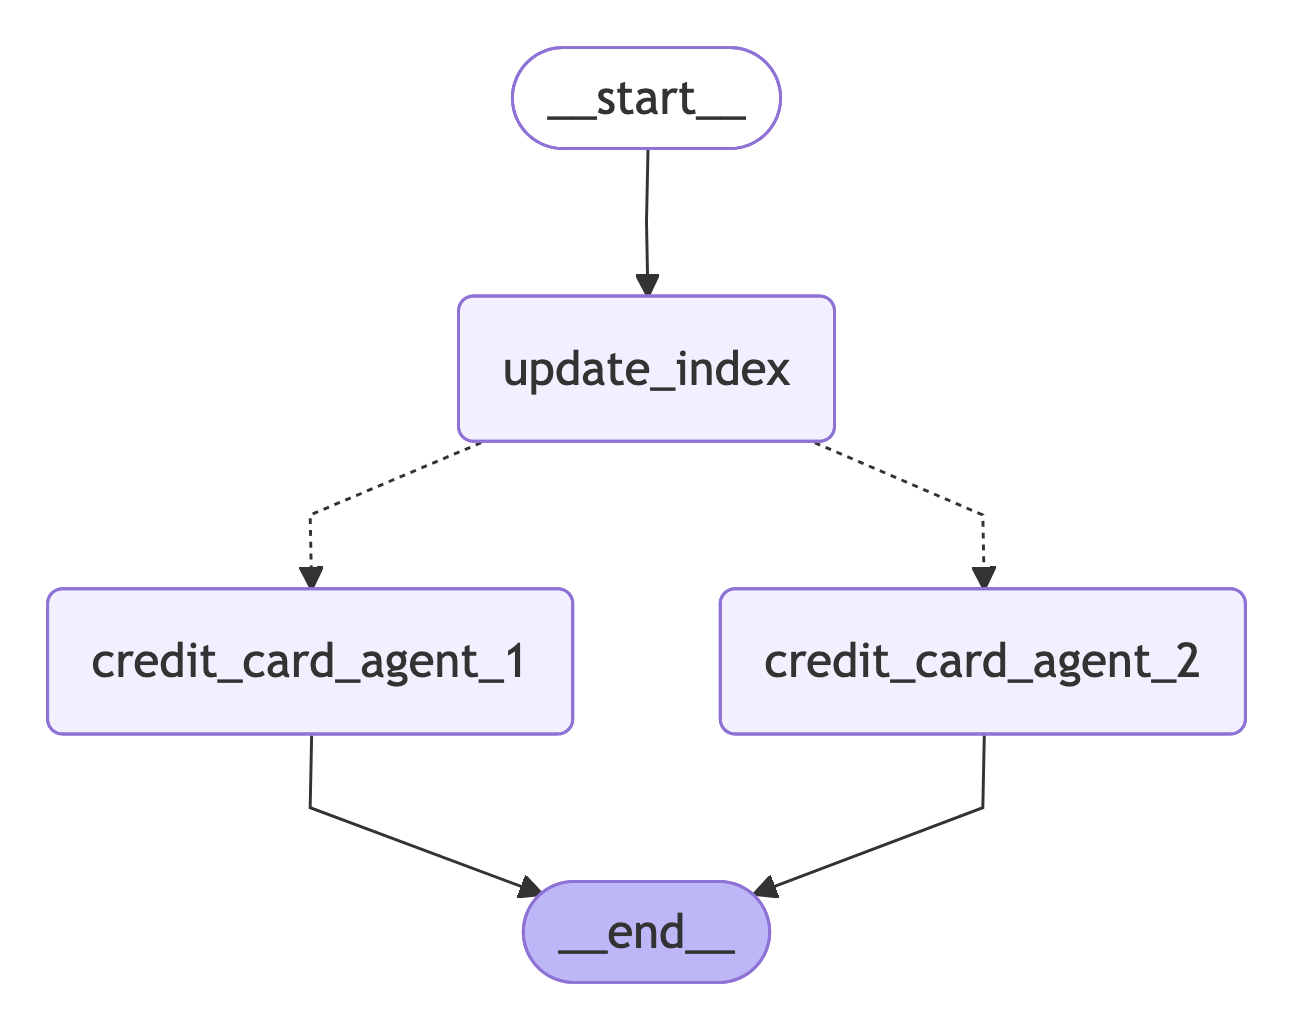

In [20]:
display(
    Image(
        agent_teams[1].get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER
        )
    )
)

## 4. Workflow Assembly

Assemble the complete routing workflow that combines urgency classification, topic classification, and team routing.

In [21]:
class FintechState(MessagesState):
    """State that tracks which team to call next within each team."""
    query: str
    agent_teams: List[CompiledStateGraph]
    agent_swarm_map: Dict[str, CompiledStateGraph]
    team_to_call: str

In [22]:
def define_agent_team(state: FintechState):
    query = state["query"]
    
    # First classify urgency
    urgency_result = classify_urgency(query)
    urgency = urgency_result["urgency"]
    
    # Then classify topic
    topic_result = classify_topic(query)
    topic = topic_result["topic"]
    
    # Define based on urgency + topic combination
    if urgency == "urgent":
        # Urgent issues go to specialized teams
        if topic == "credit_card":
            return {"team_to_call": "credit_card_team"}
        elif topic == "account":
            return {"team_to_call": "account_team"}
        elif topic == "loan":
            return {"team_to_call": "loan_team"}

    return {"team_to_call": "general_team"}


In [23]:
def trigger_agent_team(state: FintechState, config: RunnableConfig):
    query = state["query"]
    team_to_call = state["team_to_call"]
    agent_teams:List[CompiledStateGraph] = config["configurable"]["agent_teams"]
    agent_swarm_map = config["configurable"]["agent_swarm_map"]
    agent_pool_to_call:List[CompiledStateGraph] = agent_swarm_map[team_to_call]

    for team in agent_teams:
        print(team.name, team_to_call)
        if team.name == team_to_call:
            
            result = team.invoke(
                input={
                    "messages": [HumanMessage(content=query)],
                    "agent_names": [agent.name for agent in agent_pool_to_call]
                },
                config={
                    "configurable": {
                        "thread_id": "round_robin"
                    }
                }
            )
            return {"messages": result["messages"]} 
 
    raise ValueError("team_to_call is not inside agent_teams")  

In [24]:
def create_fintech_workflow():
    """
    Create the complete workflow that:
    1. Routes by urgency + topic to teams
    2. Uses round-robin within teams
    """
    workflow = StateGraph(FintechState)
    
    workflow.add_node("define_agent_team", define_agent_team)
    workflow.add_node("trigger_agent_team", trigger_agent_team)
    
    workflow.add_edge(START, "define_agent_team")
    workflow.add_edge("define_agent_team", "trigger_agent_team")
    workflow.add_edge("trigger_agent_team", END)
    
    return workflow

In [25]:
fintech_workflow = create_fintech_workflow()
fintech_graph = fintech_workflow.compile(checkpointer=MemorySaver())

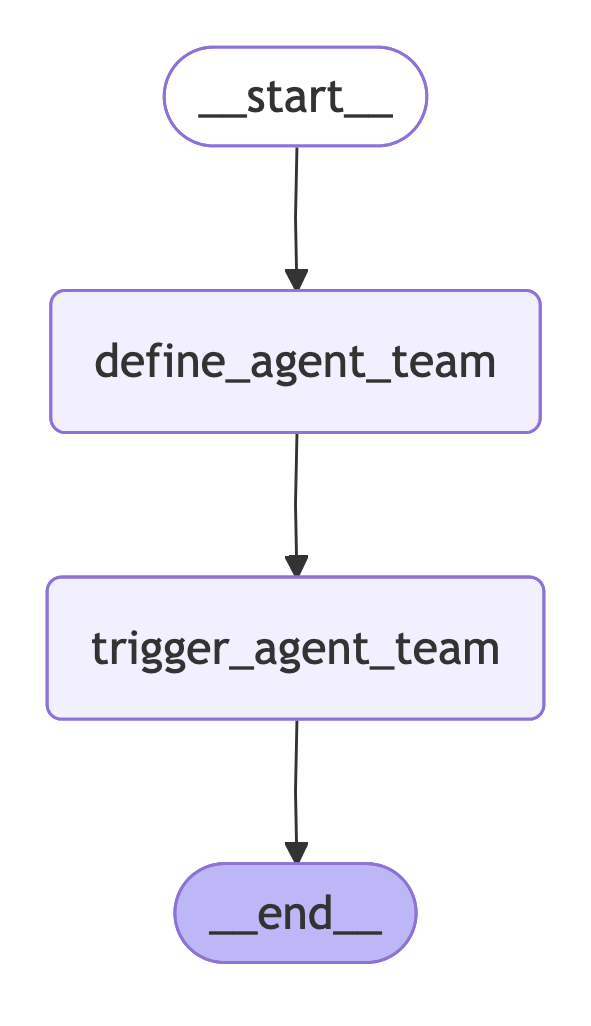

In [26]:
display(
    Image(
        fintech_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER
        )
    )
)

## 5. Run Multi Agent System

Create a function to execute the complete routing system and test it with various customer inquiries.

In [27]:
def run_multi_agent_system(
    query:str,
    graph:CompiledStateGraph, 
    thread_id:str,
    agent_teams:List[CompiledStateGraph],
    agent_swarm_map:Dict[str, CompiledStateGraph]
):
    result = graph.invoke(
        input={
            "query": query,
        },
        config={
            "configurable": {
                "thread_id": thread_id,
                "agent_teams": agent_teams,
                "agent_swarm_map": agent_swarm_map,
            }
        }
    )
    return result

In [28]:
result = run_multi_agent_system(
    query="URGENT: My credit card was stolen!",
    graph=fintech_graph, 
    thread_id="1",
    agent_teams=agent_teams,
    agent_swarm_map=agent_swarm_map,
)

general_team credit_card_team
credit_card_team credit_card_team
Round-robin Active Agent: credit_card_agent_2


In [29]:
result

{'messages': [HumanMessage(content='URGENT: My credit card was stolen!', additional_kwargs={}, response_metadata={}, id='d1f828c0-fcac-449c-b017-3180b2d2c924'),
  AIMessage(content="[CREDIT CARD] I'm sorry to hear that your credit card was stolen. It's important to act quickly to protect your account. Please follow these steps:\n\n1. **Report the Theft**: Call our customer service immediately at the number on the back of your card or our dedicated fraud hotline. We will help you freeze your account and prevent any unauthorized transactions.\n\n2. **Review Transactions**: Check your recent transactions for any unauthorized charges. Make a note of any that you did not make.\n\n3. **Update Your Information**: If you have any recurring payments linked to your stolen card, be prepared to update those with your new card information once it is issued.\n\n4. **Monitor Your Accounts**: Keep an eye on your bank statements and credit reports for any unusual activity.\n\nPlease let me know if you 

In [30]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

URGENT: My credit card was stolen!
================================== Ai Message ==================================
Name: credit_card_agent_2

[CREDIT CARD] I'm sorry to hear that your credit card was stolen. It's important to act quickly to protect your account. Please follow these steps:

1. **Report the Theft**: Call our customer service immediately at the number on the back of your card or our dedicated fraud hotline. We will help you freeze your account and prevent any unauthorized transactions.

2. **Review Transactions**: Check your recent transactions for any unauthorized charges. Make a note of any that you did not make.

3. **Update Your Information**: If you have any recurring payments linked to your stolen card, be prepared to update those with your new card information once it is issued.

4. **Monitor Your Accounts**: Keep an eye on your bank statements and credit reports for any unusual acti

In [31]:
result = run_multi_agent_system(
    query="ASAP: Fraudulent charges on my card!",
    graph=fintech_graph, 
    thread_id="1",
    agent_teams=agent_teams,
    agent_swarm_map=agent_swarm_map,
)

general_team credit_card_team
credit_card_team credit_card_team
Round-robin Active Agent: credit_card_agent_1


In [32]:
result

{'messages': [HumanMessage(content='URGENT: My credit card was stolen!', additional_kwargs={}, response_metadata={}, id='d1f828c0-fcac-449c-b017-3180b2d2c924'),
  AIMessage(content="[CREDIT CARD] I'm sorry to hear that your credit card was stolen. It's important to act quickly to protect your account. Please follow these steps:\n\n1. **Report the Theft**: Call our customer service immediately at the number on the back of your card or our dedicated fraud hotline. We will help you freeze your account and prevent any unauthorized transactions.\n\n2. **Review Transactions**: Check your recent transactions for any unauthorized charges. Make a note of any that you did not make.\n\n3. **Update Your Information**: If you have any recurring payments linked to your stolen card, be prepared to update those with your new card information once it is issued.\n\n4. **Monitor Your Accounts**: Keep an eye on your bank statements and credit reports for any unusual activity.\n\nPlease let me know if you 

In [33]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

URGENT: My credit card was stolen!
================================== Ai Message ==================================
Name: credit_card_agent_2

[CREDIT CARD] I'm sorry to hear that your credit card was stolen. It's important to act quickly to protect your account. Please follow these steps:

1. **Report the Theft**: Call our customer service immediately at the number on the back of your card or our dedicated fraud hotline. We will help you freeze your account and prevent any unauthorized transactions.

2. **Review Transactions**: Check your recent transactions for any unauthorized charges. Make a note of any that you did not make.

3. **Update Your Information**: If you have any recurring payments linked to your stolen card, be prepared to update those with your new card information once it is issued.

4. **Monitor Your Accounts**: Keep an eye on your bank statements and credit reports for any unusual acti

## 6. [Optional] Test Cases

Create comprehensive test cases to validate the routing system works correctly across different scenarios.

In [ ]:
test_cases = [
    # (message, expected_team, expected_urgency)
    ("How do I check my account balance?", "general_team", "normal"),
    ("URGENT: My credit card was stolen!", "credit_card_team", "urgent"),
    ("I can't access my account, this is critical", "account_team", "urgent"),
    ("What are the current loan rates?", "loan_team", "normal"),
    ("ASAP: Fraudulent charges on my card!", "credit_card_team", "urgent"),
    ("How do I update my contact information?", "account_team", "normal"),
    ("I need help with my loan application", "loan_team", "normal"),
    ("What products do you offer?", "general_team", "normal"),
]